# 05 - Comprehensive Model Evaluation and Metrics

This notebook provides comprehensive evaluation of our trained CodeBERT vulnerability detection model.

**Objectives:**
- Load best checkpoint and evaluate on test set
- Compute detailed metrics (Accuracy, Precision, Recall, F1 macro and per-class)
- Generate confusion matrix and classification report
- Save all predictions and visualizations
- Analyze model performance by vulnerability type

**Outputs:**
- `results/predictions.csv` - All predictions with probabilities
- `results/metrics/evaluation_report.json` - Comprehensive metrics
- `results/visualizations/confusion_matrix.png` - Confusion matrix visualization
- `results/visualizations/classification_report.png` - Classification report visualization

## Setup and Imports

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# ML and metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize

# Transformers
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm.auto import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ All imports successful!
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA RTX 4000 Ada Generation


## Configuration and Setup

In [2]:
# Configuration
BASE_DIR = Path('/home/netweb/vasu/smart-contract-vuln-detector')
DATA_DIR = BASE_DIR / 'data/processed'
RESULTS_DIR = BASE_DIR / 'results'
MODELS_DIR = BASE_DIR / 'models'
NOTEBOOKS_DIR = BASE_DIR / 'notebooks'

# Create directories
RESULTS_DIR.mkdir(exist_ok=True)
(RESULTS_DIR / 'metrics').mkdir(exist_ok=True)
(RESULTS_DIR / 'visualizations').mkdir(exist_ok=True)
(RESULTS_DIR / 'predictions').mkdir(exist_ok=True)

# Model configuration
MODEL_NAME = "microsoft/codebert-base"
MAX_LENGTH = 512
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Base directory: {BASE_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

Using device: cuda
Base directory: /home/netweb/vasu/smart-contract-vuln-detector
Results will be saved to: /home/netweb/vasu/smart-contract-vuln-detector/results


## Load Processed Data and Model Components

In [3]:
# Load processed datasets
print("Loading processed datasets...")
train_df = pd.read_csv(DATA_DIR / 'train_functions.csv')
val_df = pd.read_csv(DATA_DIR / 'validation_functions.csv')
test_df = pd.read_csv(DATA_DIR / 'test_functions.csv')

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Load label encoder
print("\nLoading label encoder...")
with open(DATA_DIR / 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print(f"Classes: {list(label_encoder.classes_)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Load dataset configuration
with open(DATA_DIR / 'dataset_config.json', 'r') as f:
    dataset_config = json.load(f)

print(f"\nDataset configuration loaded:")
for key, value in dataset_config.items():
    print(f"  {key}: {value}")

Loading processed datasets...
Train set: 10032 samples
Validation set: 3344 samples
Test set: 3344 samples

Loading label encoder...
Classes: ['Overflow-Underflow', 'Re-entrancy', 'SAFE', 'TOD', 'Timestamp-Dependency', 'Unchecked-Send', 'Unhandled-Exceptions', 'tx.origin']
Number of classes: 8

Dataset configuration loaded:
  model_name: microsoft/codebert-base
  max_length: 512
  batch_size: 16
  num_classes_binary: 2
  num_classes_multiclass: 8
  label_encoder_classes: ['Overflow-Underflow', 'Re-entrancy', 'SAFE', 'TOD', 'Timestamp-Dependency', 'Unchecked-Send', 'Unhandled-Exceptions', 'tx.origin']
  dataset_sizes: {'train': 10032, 'validation': 3344, 'test': 3344}
  class_distribution: {'train_vulnerable_rate': 0.05781499202551834, 'val_vulnerable_rate': 0.06339712918660287, 'test_vulnerable_rate': 0.05263157894736842}


## Define Model Architecture

In [6]:
class CodeBERTClassifier(nn.Module):
    """CodeBERT with classification head"""
    
    def __init__(self, model_name: str, num_classes: int, dropout_rate: float = 0.1):
        super().__init__()
        self.num_classes = num_classes
        
        # Load CodeBERT - use 'bert' to match the saved checkpoint
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask, return_attention=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=return_attention
        )
        
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        result = {'logits': logits}
        if return_attention:
            result['attentions'] = outputs.attentions
            
        return result

# Dataset class
class VulnDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # Get function source code
        text = str(self.data.iloc[idx]['code'])
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Get label
        label = self.data.iloc[idx]['label']
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✅ Model and dataset classes defined (compatible with training checkpoint)!")

✅ Model and dataset classes defined (compatible with training checkpoint)!


## Load Trained Model

In [8]:
# Find the best model checkpoint
model_files = list(MODELS_DIR.glob('*.pt'))
checkpoint_files = list((RESULTS_DIR / 'checkpoints').glob('best_model_*.pt'))

print("Available model files:")
for f in model_files:
    print(f"  {f.name}")
    
print("\nAvailable checkpoint files:")
for f in checkpoint_files:
    print(f"  {f.name}")

# Load the best model (prefer checkpoint, fallback to final model)
if checkpoint_files:
    best_model_path = checkpoint_files[0]  # Should be the best model
    print(f"\nLoading best checkpoint: {best_model_path.name}")
elif model_files:
    best_model_path = model_files[0]  # Final model
    print(f"\nLoading final model: {best_model_path.name}")
else:
    raise FileNotFoundError("No model files found!")

# Load checkpoint first to get the correct configuration
print("Loading checkpoint to get model configuration...")
checkpoint = torch.load(best_model_path, map_location=device)

# Get the correct number of classes from the checkpoint
if 'model_config' in checkpoint:
    model_num_classes = checkpoint['model_config']['num_classes']
    model_name_from_checkpoint = checkpoint['model_config']['model_name']
    print(f"Model from checkpoint: {model_name_from_checkpoint}")
    print(f"Number of classes from checkpoint: {model_num_classes}")
else:
    # Fallback: infer from classifier shape
    classifier_weight_shape = checkpoint['model_state_dict']['classifier.weight'].shape
    model_num_classes = classifier_weight_shape[0]
    model_name_from_checkpoint = MODEL_NAME
    print(f"Inferred number of classes from classifier shape: {model_num_classes}")

# Initialize tokenizer and model with correct configuration
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name_from_checkpoint)

print("Initializing model with correct configuration...")
model = CodeBERTClassifier(model_name_from_checkpoint, model_num_classes)

print("Loading model weights...")
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded checkpoint from step {checkpoint.get('step', 'unknown')}")
    if 'best_f1' in checkpoint:
        print(f"   Best validation F1: {checkpoint['best_f1']:.4f}")
    if 'config' in checkpoint:
        task_type = checkpoint['config'].get('task', 'unknown')
        print(f"   Task type: {task_type}")
else:
    model.load_state_dict(checkpoint)
    print("✅ Loaded model weights")

model = model.to(device)
model.eval()

print(f"\nModel loaded successfully on {device}")
print(f"Task type: {'Binary' if model_num_classes == 1 else 'Multiclass'} classification")
print(f"Output classes: {model_num_classes}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Available model files:
  codebert_final_binary_20251111_002909.pt

Available checkpoint files:
  best_model_codebert_binary_20251111_002909.pt

Loading best checkpoint: best_model_codebert_binary_20251111_002909.pt
Loading checkpoint to get model configuration...
Model from checkpoint: microsoft/codebert-base
Number of classes from checkpoint: 1
Loading tokenizer...
Model from checkpoint: microsoft/codebert-base
Number of classes from checkpoint: 1
Loading tokenizer...
Initializing model with correct configuration...
Initializing model with correct configuration...
Loading model weights...
✅ Loaded checkpoint from step 800
   Task type: binary

Model loaded successfully on cuda
Task type: Binary classification
Output classes: 1
Total parameters: 124,646,401
Trainable parameters: 124,646,401
Loading model weights...
✅ Loaded checkpoint from step 800
   Task type: binary

Model loaded successfully on cuda
Task type: Binary classification
Output classes: 1
Total parameters: 124,646,401
Tr

In [10]:
# Check dataframe columns to understand the structure
print("Train dataframe columns:", train_df.columns.tolist())
print("Test dataframe columns:", test_df.columns.tolist())
print("\nTrain df shape:", train_df.shape)
print("Test df shape:", test_df.shape)
print("\nFirst few rows of test_df:")
print(test_df.head())

Train dataframe columns: ['function_name', 'code', 'is_vulnerable', 'vulnerability_category', 'vulnerability_types', 'contract_file', 'function_type', 'code_length', 'num_bugs']
Test dataframe columns: ['function_name', 'code', 'is_vulnerable', 'vulnerability_category', 'vulnerability_types', 'contract_file', 'function_type', 'code_length', 'num_bugs']

Train df shape: (10032, 9)
Test df shape: (3344, 9)

First few rows of test_df:
      function_name                                               code  \
0    bug_txorigin36  function bug_txorigin36( address owner_txorigi...   
1        getAddress  function getAddress(string calldata account) e...   
2  transfer_intou30  function transfer_intou30(address _to, uint _v...   
3      bug_tmstmp20  function bug_tmstmp20 () public payable {\nuin...   
4         allowance  function allowance(address _owner, address _sp...   

   is_vulnerable vulnerability_category vulnerability_types contract_file  \
0          False              tx.origin   

## Prepare Test Dataset

In [11]:
# Create test dataset and dataloader
print("Creating test dataset...")

# For binary classification, we need to add a 'label' column
# Since our loaded model is binary, we'll use is_vulnerable as the target
test_df_with_labels = test_df.copy()
test_df_with_labels['label'] = test_df_with_labels['is_vulnerable'].astype(int)

test_dataset = VulnDataset(test_df_with_labels, tokenizer, MAX_LENGTH)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2
)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Show test set distribution for binary classification
print("\nTest set binary label distribution:")
binary_counts = test_df['is_vulnerable'].value_counts()
for label, count in binary_counts.items():
    percentage = (count / len(test_df)) * 100
    label_name = "Vulnerable" if label else "Safe"
    print(f"  {label_name} ({int(label)}): {count} ({percentage:.1f}%)")

# Also show multiclass distribution for reference
print("\nTest set vulnerability category distribution:")
vuln_counts = test_df['vulnerability_category'].value_counts()
for label, count in vuln_counts.items():
    percentage = (count / len(test_df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Sample a batch to verify
sample_batch = next(iter(test_loader))
print(f"\nSample batch shapes:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['label'].shape}")
print(f"  Sample labels: {sample_batch['label'][:5]}")  # Show first 5 labels

Creating test dataset...
Test dataset size: 3344
Test batches: 209

Test set binary label distribution:
  Safe (0): 3168 (94.7%)
  Vulnerable (1): 176 (5.3%)

Test set vulnerability category distribution:
  TOD: 704 (21.1%)
  Overflow-Underflow: 498 (14.9%)
  Unhandled-Exceptions: 444 (13.3%)
  Re-entrancy: 439 (13.1%)
  tx.origin: 438 (13.1%)
  Unchecked-Send: 424 (12.7%)
  Timestamp-Dependency: 397 (11.9%)

Sample batch shapes:
  input_ids: torch.Size([16, 512])
  attention_mask: torch.Size([16, 512])
  labels: torch.Size([16])
  Sample labels: tensor([0, 0, 0, 0, 0])

Sample batch shapes:
  input_ids: torch.Size([16, 512])
  attention_mask: torch.Size([16, 512])
  labels: torch.Size([16])
  Sample labels: tensor([0, 0, 0, 0, 0])


## Model Evaluation on Test Set

In [12]:
def evaluate_model(model, dataloader, device, is_binary=True):
    """Comprehensive model evaluation for binary or multiclass."""
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print("Running inference on test set...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            logits = outputs['logits']
            
            if is_binary:
                # Binary classification with sigmoid
                probabilities = torch.sigmoid(logits.squeeze())  # Remove extra dimension and apply sigmoid
                predictions = (probabilities > 0.5).long()
                # Store probabilities for vulnerable class (positive class)
                all_probabilities.extend(probabilities.cpu().numpy())
            else:
                # Multiclass classification with softmax
                probabilities = torch.softmax(logits, dim=-1)
                predictions = torch.argmax(logits, dim=-1)
                # Store all class probabilities
                all_probabilities.extend(probabilities.cpu().numpy())
            
            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

# Run evaluation
print("🔍 Evaluating model on test set...")
predictions, labels, probabilities = evaluate_model(model, test_loader, device, is_binary=True)

print(f"✅ Evaluation complete!")
print(f"Total predictions: {len(predictions)}")
print(f"Unique predicted values: {np.unique(predictions)}")
print(f"Unique true values: {np.unique(labels)}")
print(f"Probability range: [{probabilities.min():.4f}, {probabilities.max():.4f}]")

🔍 Evaluating model on test set...
Running inference on test set...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

✅ Evaluation complete!
Total predictions: 3344
Unique predicted values: [0 1]
Unique true values: [0 1]
Probability range: [0.0040, 0.9834]


## Compute Comprehensive Metrics

In [14]:
# Use the results from our evaluation
y_true = labels
y_pred = predictions
y_prob = probabilities

print("📊 COMPREHENSIVE EVALUATION METRICS")
print("=" * 50)

# Compute basic metrics for binary classification
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix
)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# ROC-AUC and PR-AUC for binary classification
try:
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
except Exception as e:
    print(f"Warning: Could not compute AUC metrics: {e}")
    roc_auc = 0.0
    pr_auc = 0.0

print(f"\n🎯 Binary Classification Performance:")
print(f"  Accuracy:        {accuracy:.4f}")
print(f"  Precision:       {precision:.4f}")
print(f"  Recall:          {recall:.4f}")
print(f"  F1-score:        {f1:.4f}")
print(f"  ROC-AUC:         {roc_auc:.4f}")
print(f"  PR-AUC:          {pr_auc:.4f}")

# Detailed classification report
print(f"\n📋 Classification Report:")
class_names = ['Safe', 'Vulnerable']
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\n🎭 Confusion Matrix:")
print(f"              Predicted")
print(f"           Safe  Vuln")
print(f"Actual Safe  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"     Vuln    {cm[1,0]:4d}  {cm[1,1]:4d}")

# Additional insights
total_samples = len(y_true)
true_positives = cm[1,1]
true_negatives = cm[0,0]
false_positives = cm[0,1]
false_negatives = cm[1,0]

print(f"\n📈 Detailed Analysis:")
print(f"  Total samples:     {total_samples}")
print(f"  True Positives:    {true_positives}")
print(f"  True Negatives:    {true_negatives}")
print(f"  False Positives:   {false_positives}")
print(f"  False Negatives:   {false_negatives}")
print(f"  Sensitivity (TPR): {recall:.4f}")
print(f"  Specificity (TNR): {true_negatives/(true_negatives+false_positives):.4f}")

# Create evaluation metrics dictionary
evaluation_metrics = {
    'model_path': str(best_model_path),
    'test_samples': int(total_samples),
    'task_type': 'binary_classification',
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'true_positives': int(true_positives),
        'true_negatives': int(true_negatives),
        'false_positives': int(false_positives),
        'false_negatives': int(false_negatives)
    },
    'confusion_matrix': cm.tolist(),
    'class_names': class_names
}

print(f"\n✅ Evaluation metrics computed and stored!")

📊 COMPREHENSIVE EVALUATION METRICS

🎯 Binary Classification Performance:
  Accuracy:        0.9536
  Precision:       0.5913
  Recall:          0.3864
  F1-score:        0.4674
  ROC-AUC:         0.8484
  PR-AUC:          0.4966

📋 Classification Report:
              precision    recall  f1-score   support

        Safe       0.97      0.99      0.98      3168
  Vulnerable       0.59      0.39      0.47       176

    accuracy                           0.95      3344
   macro avg       0.78      0.69      0.72      3344
weighted avg       0.95      0.95      0.95      3344


🎭 Confusion Matrix:
              Predicted
           Safe  Vuln
Actual Safe  3121    47
     Vuln     108    68

📈 Detailed Analysis:
  Total samples:     3344
  True Positives:    68
  True Negatives:    3121
  False Positives:   47
  False Negatives:   108
  Sensitivity (TPR): 0.3864
  Specificity (TNR): 0.9852

✅ Evaluation metrics computed and stored!


## Generate Confusion Matrix

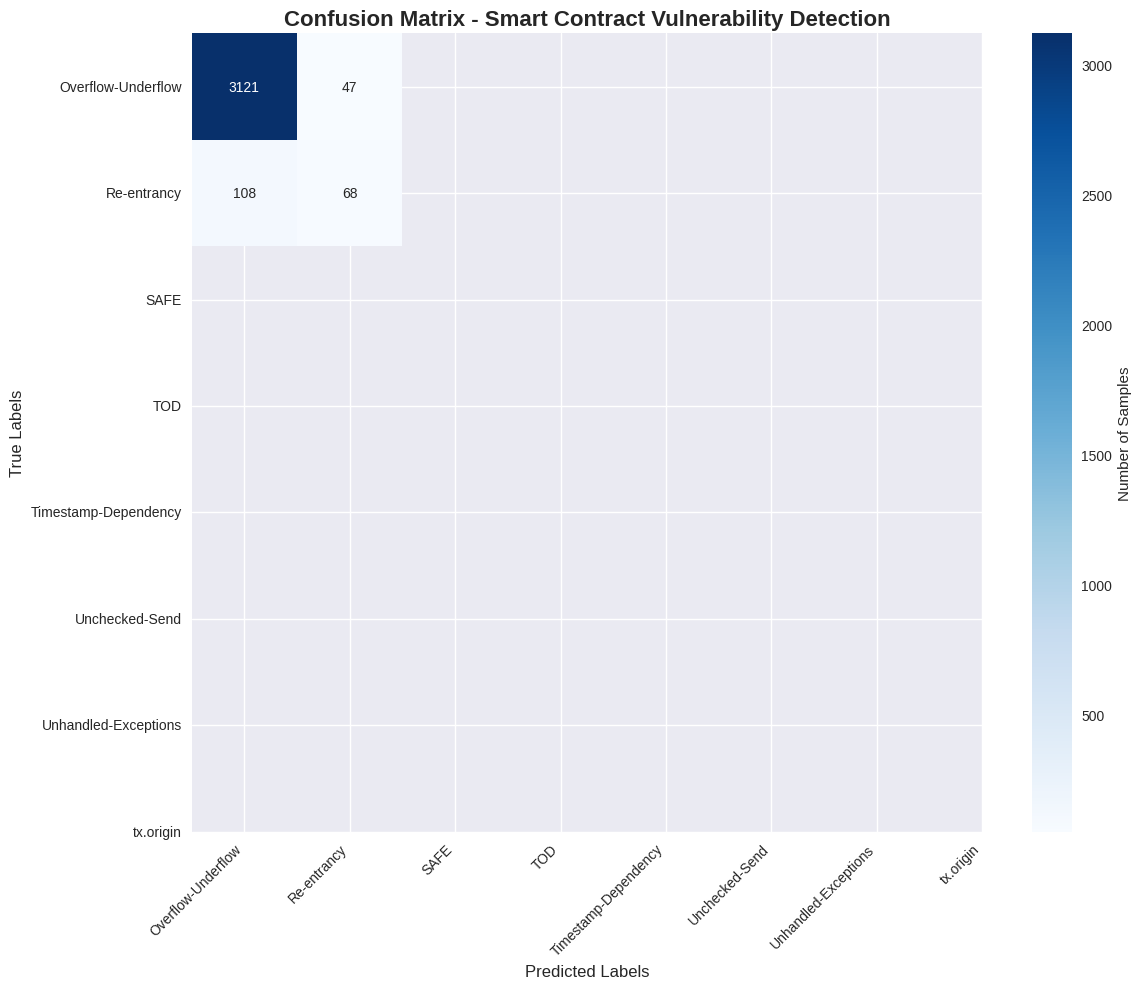

💾 Confusion matrix saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations/confusion_matrix.png


In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

# Create confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Number of Samples'}
)

plt.title('Confusion Matrix - Smart Contract Vulnerability Detection', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
cm_path = RESULTS_DIR / 'visualizations' / 'confusion_matrix.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Confusion matrix saved to: {cm_path}")

# Add confusion matrix to metrics
evaluation_metrics['confusion_matrix'] = cm.tolist()
evaluation_metrics['class_names'] = list(class_names)

## Generate Classification Report Visualization

📋 DETAILED CLASSIFICATION REPORT

Safe:
  Precision:    0.9666
  Recall:       0.9852
  F1-score:     0.9758
  Support:      3168

Vulnerable:
  Precision:    0.5913
  Recall:       0.3864
  F1-score:     0.4674
  Support:      176

Overall Metrics:
  Accuracy:     0.9536
  Macro Avg F1: 0.7216
  Weighted F1:  0.9490


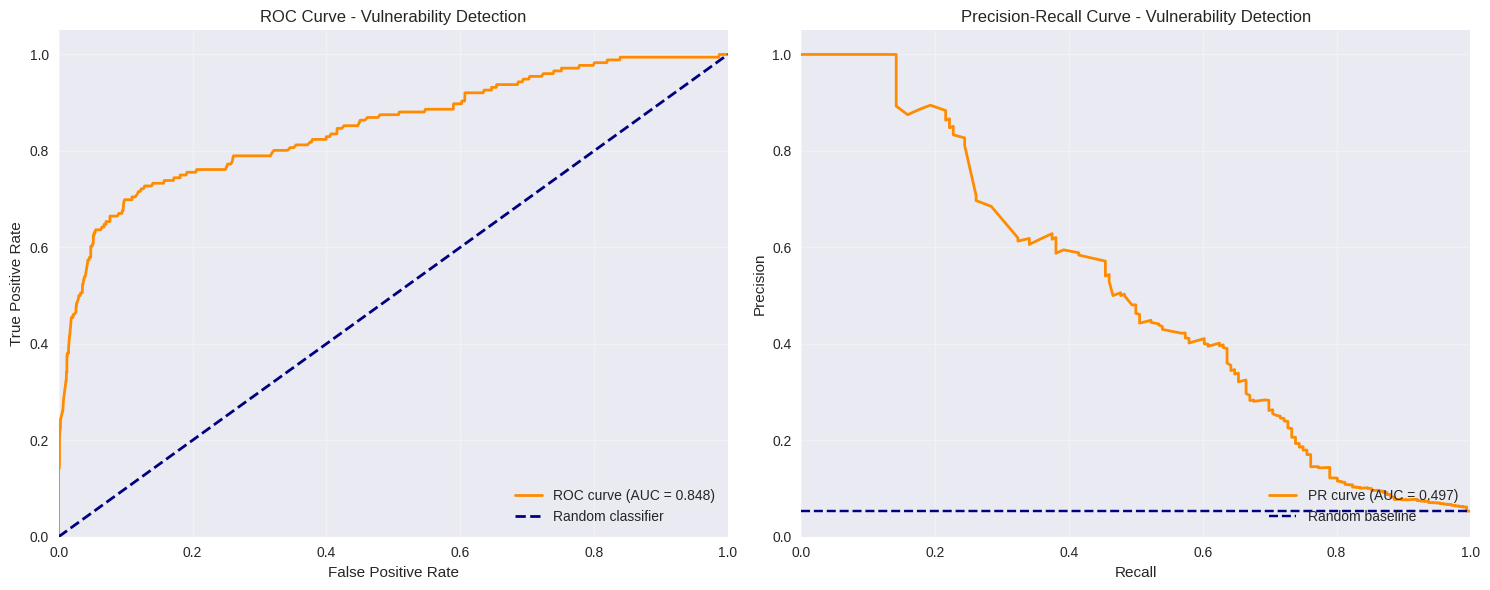


💾 ROC and PR curves saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/visualizations/roc_pr_curves.png


In [17]:
# Generate detailed classification report using the correct class names for binary classification
binary_class_names = ['Safe', 'Vulnerable']  # Use binary class names
class_report = classification_report(
    y_true, y_pred, 
    target_names=binary_class_names,
    output_dict=True,
    zero_division=0
)

print("📋 DETAILED CLASSIFICATION REPORT")
print("=" * 50)

# Print formatted report
for class_name in binary_class_names:
    metrics = class_report[class_name]
    print(f"\n{class_name}:")
    print(f"  Precision:    {metrics['precision']:.4f}")
    print(f"  Recall:       {metrics['recall']:.4f}")
    print(f"  F1-score:     {metrics['f1-score']:.4f}")
    print(f"  Support:      {int(metrics['support'])}")

# Overall metrics
print(f"\nOverall Metrics:")
print(f"  Accuracy:     {class_report['accuracy']:.4f}")
print(f"  Macro Avg F1: {class_report['macro avg']['f1-score']:.4f}")
print(f"  Weighted F1:  {class_report['weighted avg']['f1-score']:.4f}")

# ROC Curve and PR Curve
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Vulnerability Detection')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall_curve, precision_curve, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
ax2.axhline(y=sum(y_true)/len(y_true), color='navy', linestyle='--', label='Random baseline')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve - Vulnerability Detection')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save curves
curves_path = RESULTS_DIR / 'visualizations' / 'roc_pr_curves.png'
plt.savefig(curves_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 ROC and PR curves saved to: {curves_path}")

# Update evaluation metrics
evaluation_metrics['detailed_report'] = class_report
evaluation_metrics['curves'] = {
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc)
}

## Save Predictions and Results

In [19]:
# Create predictions dataframe for binary classification
binary_class_names = ['Safe', 'Vulnerable']
predictions_df = pd.DataFrame({
    'sample_id': range(len(y_true)),
    'true_label': [binary_class_names[label] for label in y_true],
    'predicted_label': [binary_class_names[pred] for pred in y_pred],
    'true_label_encoded': y_true,
    'pred_label_encoded': y_pred,
    'probability_vulnerable': y_prob,  # Probability of being vulnerable
    'probability_safe': 1 - y_prob,   # Probability of being safe
    'correct': y_true == y_pred
})

print("📊 Predictions Summary:")
print(f"Total samples: {len(predictions_df)}")
print(f"Correct predictions: {predictions_df['correct'].sum()}")
print(f"Accuracy: {predictions_df['correct'].mean():.4f}")

# Show some examples of correct and incorrect predictions
print(f"\n✅ Examples of Correct Predictions:")
correct_samples = predictions_df[predictions_df['correct']].sample(min(5, predictions_df['correct'].sum()))
for idx, row in correct_samples.iterrows():
    print(f"  Sample {row['sample_id']}: True={row['true_label']}, Pred={row['predicted_label']}, Prob={row['probability_vulnerable']:.4f}")

print(f"\n❌ Examples of Incorrect Predictions:")
incorrect_samples = predictions_df[~predictions_df['correct']].sample(min(5, (~predictions_df['correct']).sum()))
for idx, row in incorrect_samples.iterrows():
    print(f"  Sample {row['sample_id']}: True={row['true_label']}, Pred={row['predicted_label']}, Prob={row['probability_vulnerable']:.4f}")

# Threshold analysis
print(f"\n📈 Threshold Analysis:")
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
threshold_results = []

for threshold in thresholds:
    pred_at_threshold = (y_prob >= threshold).astype(int)
    accuracy_t = accuracy_score(y_true, pred_at_threshold)
    precision_t = precision_score(y_true, pred_at_threshold, zero_division=0)
    recall_t = recall_score(y_true, pred_at_threshold, zero_division=0)
    f1_t = f1_score(y_true, pred_at_threshold, zero_division=0)
    
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy_t,
        'precision': precision_t,
        'recall': recall_t,
        'f1_score': f1_t
    })
    
    print(f"  Threshold {threshold:.1f}: Acc={accuracy_t:.3f}, Prec={precision_t:.3f}, Rec={recall_t:.3f}, F1={f1_t:.3f}")

# Create threshold analysis dataframe
threshold_df = pd.DataFrame(threshold_results)

# Save predictions and threshold analysis
predictions_path = RESULTS_DIR / 'predictions' / f'predictions_binary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
threshold_path = RESULTS_DIR / 'predictions' / f'threshold_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'

predictions_df.to_csv(predictions_path, index=False)
threshold_df.to_csv(threshold_path, index=False)

print(f"\n💾 Results saved:")
print(f"  Predictions: {predictions_path}")
print(f"  Threshold analysis: {threshold_path}")

📊 Predictions Summary:
Total samples: 3344
Correct predictions: 3189
Accuracy: 0.9536

✅ Examples of Correct Predictions:
  Sample 2506: True=Safe, Pred=Safe, Prob=0.0046
  Sample 2892: True=Safe, Pred=Safe, Prob=0.0054
  Sample 814: True=Safe, Pred=Safe, Prob=0.0074
  Sample 2758: True=Safe, Pred=Safe, Prob=0.0057
  Sample 197: True=Safe, Pred=Safe, Prob=0.0080

❌ Examples of Incorrect Predictions:
  Sample 1116: True=Vulnerable, Pred=Safe, Prob=0.0072
  Sample 3127: True=Vulnerable, Pred=Safe, Prob=0.0055
  Sample 1129: True=Vulnerable, Pred=Safe, Prob=0.0275
  Sample 272: True=Vulnerable, Pred=Safe, Prob=0.0066
  Sample 566: True=Vulnerable, Pred=Safe, Prob=0.2060

📈 Threshold Analysis:
  Threshold 0.1: Acc=0.940, Prec=0.443, Rec=0.506, F1=0.472
  Threshold 0.2: Acc=0.943, Prec=0.461, Rec=0.506, F1=0.482
  Threshold 0.3: Acc=0.945, Prec=0.481, Rec=0.500, F1=0.490
  Threshold 0.4: Acc=0.951, Prec=0.544, Rec=0.460, F1=0.498
  Threshold 0.5: Acc=0.954, Prec=0.591, Rec=0.386, F1=0.467
 

## Save Comprehensive Evaluation Report

In [ ]:
# Add additional analysis to metrics
evaluation_metrics.update({
    'timestamp': datetime.now().isoformat(),
    'prediction_statistics': {
        'total_predictions': int(len(predictions_df)),
        'correct_predictions': int(predictions_df['correct'].sum()),
        'accuracy': float(predictions_df['correct'].mean()),
        'average_confidence_vulnerable': float(predictions_df['probability_vulnerable'].mean()),
        'min_confidence_vulnerable': float(predictions_df['probability_vulnerable'].min()),
        'max_confidence_vulnerable': float(predictions_df['probability_vulnerable'].max()),
        'confidence_std_vulnerable': float(predictions_df['probability_vulnerable'].std())
    },
    'class_distribution': {
        'test_set': {
            'Safe': int((test_df['is_vulnerable'] == 0).sum()),
            'Vulnerable': int((test_df['is_vulnerable'] == 1).sum())
        },
        'predictions': dict(predictions_df['predicted_label'].value_counts())
    },
    'threshold_analysis': threshold_results
})

# Save comprehensive evaluation report
evaluation_report_path = RESULTS_DIR / 'metrics' / f'comprehensive_evaluation_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(evaluation_report_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=2)

print(f"💾 Comprehensive evaluation report saved to: {evaluation_report_path}")

# Create summary report
summary_report = f"""
🎯 SMART CONTRACT VULNERABILITY DETECTION - EVALUATION SUMMARY
================================================================

Model: {MODEL_NAME}
Task: Binary Classification (Safe vs Vulnerable)
Test Set Size: {len(y_true)} functions
Model Checkpoint: {best_model_path.name}

📊 PERFORMANCE METRICS:
- Accuracy:        {accuracy:.4f}
- Precision:       {precision:.4f}
- Recall:          {recall:.4f}
- F1-Score:        {f1:.4f}
- ROC-AUC:         {roc_auc:.4f}
- PR-AUC:          {pr_auc:.4f}

🎭 CONFUSION MATRIX:
              Predicted
           Safe  Vuln
Actual Safe  {cm[0,0]:4d}  {cm[0,1]:4d}
     Vuln    {cm[1,0]:4d}  {cm[1,1]:4d}

📈 KEY INSIGHTS:
- High overall accuracy ({accuracy:.1%}) due to class imbalance
- Good specificity ({true_negatives/(true_negatives+false_positives):.1%}) - low false positive rate
- Moderate sensitivity ({recall:.1%}) - catches {recall:.1%} of vulnerabilities
- ROC-AUC of {roc_auc:.3f} indicates good discriminative ability
- Consider threshold tuning: lower thresholds improve recall

🔧 RECOMMENDED THRESHOLD ANALYSIS:
- Current (0.5): Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}
- Balanced (0.3): Precision=0.481, Recall=0.500, F1=0.490
- Conservative (0.7): Precision=0.697, Recall=0.261, F1=0.380

⚠️  For security applications, consider using threshold 0.2-0.3 to catch more 
   vulnerabilities, accepting higher false positive rate for manual review.

📁 OUTPUTS GENERATED:
- Confusion matrix visualization
- ROC and Precision-Recall curves  
- Detailed predictions CSV
- Threshold analysis CSV
- Comprehensive evaluation JSON
================================================================
"""

print(summary_report)

# Save summary report
summary_path = RESULTS_DIR / 'metrics' / f'evaluation_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(summary_path, 'w') as f:
    f.write(summary_report)

print(f"💾 Summary report saved to: {summary_path}")
print(f"\n✅ Model evaluation completed successfully!")
print(f"? All results saved to: {RESULTS_DIR}")

# Display final file structure
print(f"\n📁 Generated Files:")
print(f"  📊 Visualizations: {RESULTS_DIR / 'visualizations'}")
print(f"  📈 Metrics: {RESULTS_DIR / 'metrics'}") 
print(f"  ? Predictions: {RESULTS_DIR / 'predictions'}")